In [3]:
# Moe ParT modified to store router output, accessed via MoeRouterHook

In [4]:
import math
import random
import warnings
import copy
import torch
import torch.nn as nn
from functools import partial
import logging
import numpy as np

_logger = logging.getLogger(__name__)

@torch.jit.script
def delta_phi(a, b):
    return (a - b + math.pi) % (2 * math.pi) - math.pi


@torch.jit.script
def delta_r2(eta1, phi1, eta2, phi2):
    return (eta1 - eta2)**2 + delta_phi(phi1, phi2)**2


def to_pt2(x, eps=1e-8):
    pt2 = x[:, :2].square().sum(dim=1, keepdim=True)
    if eps is not None:
        pt2 = pt2.clamp(min=eps)
    return pt2


def to_m2(x, eps=1e-8):
    m2 = x[:, 3:4].square() - x[:, :3].square().sum(dim=1, keepdim=True)
    if eps is not None:
        m2 = m2.clamp(min=eps)
    return m2


def atan2(y, x):
    sx = torch.sign(x)
    sy = torch.sign(y)
    pi_part = (sy + sx * (sy ** 2 - 1)) * (sx - 1) * (-math.pi / 2)
    atan_part = torch.arctan(y / (x + (1 - sx ** 2))) * sx ** 2
    return atan_part + pi_part


def to_ptrapphim(x, return_mass=True, eps=1e-8, for_onnx=False):
    # x: (N, 4, ...), dim1 : (px, py, pz, E)
    px, py, pz, energy = x.split((1, 1, 1, 1), dim=1)
    pt = torch.sqrt(to_pt2(x, eps=eps))
    # rapidity = 0.5 * torch.log((energy + pz) / (energy - pz))
    rapidity = 0.5 * torch.log(1 + (2 * pz) / (energy - pz).clamp(min=1e-20))
    phi = (atan2 if for_onnx else torch.atan2)(py, px)
    if not return_mass:
        return torch.cat((pt, rapidity, phi), dim=1)
    else:
        m = torch.sqrt(to_m2(x, eps=eps))
        return torch.cat((pt, rapidity, phi, m), dim=1)


def boost(x, boostp4, eps=1e-8):
    # boost x to the rest frame of boostp4
    # x: (N, 4, ...), dim1 : (px, py, pz, E)
    p3 = -boostp4[:, :3] / boostp4[:, 3:].clamp(min=eps)
    b2 = p3.square().sum(dim=1, keepdim=True)
    gamma = (1 - b2).clamp(min=eps)**(-0.5)
    gamma2 = (gamma - 1) / b2
    gamma2.masked_fill_(b2 == 0, 0)
    bp = (x[:, :3] * p3).sum(dim=1, keepdim=True)
    v = x[:, :3] + gamma2 * bp * p3 + x[:, 3:] * gamma * p3
    return v


def p3_norm(p, eps=1e-8):
    return p[:, :3] / p[:, :3].norm(dim=1, keepdim=True).clamp(min=eps)


def pairwise_lv_fts(xi, xj, num_outputs=4, eps=1e-8, for_onnx=False):
    pti, rapi, phii = to_ptrapphim(xi, False, eps=None, for_onnx=for_onnx).split((1, 1, 1), dim=1)
    ptj, rapj, phij = to_ptrapphim(xj, False, eps=None, for_onnx=for_onnx).split((1, 1, 1), dim=1)

    delta = delta_r2(rapi, phii, rapj, phij).sqrt()
    lndelta = torch.log(delta.clamp(min=eps))
    if num_outputs == 1:
        return lndelta

    if num_outputs > 1:
        ptmin = ((pti <= ptj) * pti + (pti > ptj) * ptj) if for_onnx else torch.minimum(pti, ptj)
        lnkt = torch.log((ptmin * delta).clamp(min=eps))
        lnz = torch.log((ptmin / (pti + ptj).clamp(min=eps)).clamp(min=eps))
        outputs = [lnkt, lnz, lndelta]

    if num_outputs > 3:
        xij = xi + xj
        lnm2 = torch.log(to_m2(xij, eps=eps))
        outputs.append(lnm2)

    if num_outputs > 4:
        lnds2 = torch.log(torch.clamp(-to_m2(xi - xj, eps=None), min=eps))
        outputs.append(lnds2)

    # the following features are not symmetric for (i, j)
    if num_outputs > 5:
        xj_boost = boost(xj, xij)
        costheta = (p3_norm(xj_boost, eps=eps) * p3_norm(xij, eps=eps)).sum(dim=1, keepdim=True)
        outputs.append(costheta)

    if num_outputs > 6:
        deltarap = rapi - rapj
        deltaphi = delta_phi(phii, phij)
        outputs += [deltarap, deltaphi]

    assert (len(outputs) == num_outputs)
    return torch.cat(outputs, dim=1)


def build_sparse_tensor(uu, idx, seq_len):
    # inputs: uu (N, C, num_pairs), idx (N, 2, num_pairs)
    # return: (N, C, seq_len, seq_len)
    batch_size, num_fts, num_pairs = uu.size()
    idx = torch.min(idx, torch.ones_like(idx) * seq_len)
    i = torch.cat((
        torch.arange(0, batch_size, device=uu.device).repeat_interleave(num_fts * num_pairs).unsqueeze(0),
        torch.arange(0, num_fts, device=uu.device).repeat_interleave(num_pairs).repeat(batch_size).unsqueeze(0),
        idx[:, :1, :].expand_as(uu).flatten().unsqueeze(0),
        idx[:, 1:, :].expand_as(uu).flatten().unsqueeze(0),
    ), dim=0)
    return torch.sparse_coo_tensor(
        i, uu.flatten(),
        size=(batch_size, num_fts, seq_len + 1, seq_len + 1),
        device=uu.device).to_dense()[:, :, :seq_len, :seq_len]


def trunc_normal_(tensor, mean=0., std=1., a=-2., b=2.):
    # From https://github.com/rwightman/pytorch-image-models/blob/18ec173f95aa220af753358bf860b16b6691edb2/timm/layers/weight_init.py#L8
    r"""Fills the input Tensor with values drawn from a truncated
    normal distribution. The values are effectively drawn from the
    normal distribution :math:`\mathcal{N}(\text{mean}, \text{std}^2)`
    with values outside :math:`[a, b]` redrawn until they are within
    the bounds. The method used for generating the random values works
    best when :math:`a \leq \text{mean} \leq b`.
    Args:
        tensor: an n-dimensional `torch.Tensor`
        mean: the mean of the normal distribution
        std: the standard deviation of the normal distribution
        a: the minimum cutoff value
        b: the maximum cutoff value
    Examples:
        >>> w = torch.empty(3, 5)
        >>> nn.init.trunc_normal_(w)
    """
    def norm_cdf(x):
        # Computes standard normal cumulative distribution function
        return (1. + math.erf(x / math.sqrt(2.))) / 2.

    if (mean < a - 2 * std) or (mean > b + 2 * std):
        warnings.warn("mean is more than 2 std from [a, b] in nn.init.trunc_normal_. "
                      "The distribution of values may be incorrect.",
                      stacklevel=2)

    with torch.no_grad():
        # Values are generated by using a truncated uniform distribution and
        # then using the inverse CDF for the normal distribution.
        # Get upper and lower cdf values
        l = norm_cdf((a - mean) / std)
        u = norm_cdf((b - mean) / std)

        # Uniformly fill tensor with values from [l, u], then translate to
        # [2l-1, 2u-1].
        tensor.uniform_(2 * l - 1, 2 * u - 1)

        # Use inverse cdf transform for normal distribution to get truncated
        # standard normal
        tensor.erfinv_()

        # Transform to proper mean, std
        tensor.mul_(std * math.sqrt(2.))
        tensor.add_(mean)

        # Clamp to ensure it's in the proper range
        tensor.clamp_(min=a, max=b)
        return tensor


class SequenceTrimmer(nn.Module):

    def __init__(self, enabled=False, target=(0.9, 1.02), **kwargs) -> None:
        super().__init__(**kwargs)
        self.enabled = enabled
        self.target = target
        self._counter = 0

    def forward(self, x, v=None, mask=None, uu=None):
        # x: (N, C, P)
        # v: (N, 4, P) [px,py,pz,energy]
        # mask: (N, 1, P) -- real particle = 1, padded = 0
        # uu: (N, C', P, P)
        if mask is None:
            mask = torch.ones_like(x[:, :1])
        mask = mask.bool()

        if self.enabled:
            if self._counter < 5:
                self._counter += 1
            else:
                if self.training:
                    q = min(1, random.uniform(*self.target))
                    maxlen = torch.quantile(mask.type_as(x).sum(dim=-1), q).long()
                    rand = torch.rand_like(mask.type_as(x))
                    rand.masked_fill_(~mask, -1)
                    perm = rand.argsort(dim=-1, descending=True)  # (N, 1, P)
                    mask = torch.gather(mask, -1, perm)
                    x = torch.gather(x, -1, perm.expand_as(x))
                    if v is not None:
                        v = torch.gather(v, -1, perm.expand_as(v))
                    if uu is not None:
                        uu = torch.gather(uu, -2, perm.unsqueeze(-1).expand_as(uu))
                        uu = torch.gather(uu, -1, perm.unsqueeze(-2).expand_as(uu))
                else:
                    maxlen = mask.sum(dim=-1).max()
                maxlen = max(maxlen, 1)
                if maxlen < mask.size(-1):
                    mask = mask[:, :, :maxlen]
                    x = x[:, :, :maxlen]
                    if v is not None:
                        v = v[:, :, :maxlen]
                    if uu is not None:
                        uu = uu[:, :, :maxlen, :maxlen]

        return x, v, mask, uu


class Embed(nn.Module):
    def __init__(self, input_dim, dims, normalize_input=True, activation='gelu'):
        super().__init__()

        self.input_bn = nn.BatchNorm1d(input_dim) if normalize_input else None
        module_list = []
        for dim in dims:
            module_list.extend([
                nn.LayerNorm(input_dim),
                nn.Linear(input_dim, dim),
                nn.GELU() if activation == 'gelu' else nn.ReLU(),
            ])
            input_dim = dim
        self.embed = nn.Sequential(*module_list)

    def forward(self, x):
        if self.input_bn is not None:
            # x: (batch, embed_dim, seq_len)
            x = self.input_bn(x)
            x = x.permute(2, 0, 1).contiguous()
        # x: (seq_len, batch, embed_dim)
        return self.embed(x)


class PairEmbed(nn.Module):
    def __init__(
            self, pairwise_lv_dim, pairwise_input_dim, dims,
            remove_self_pair=False, use_pre_activation_pair=True, mode='sum',
            normalize_input=True, activation='gelu', eps=1e-8,
            for_onnx=False):
        super().__init__()

        self.pairwise_lv_dim = pairwise_lv_dim
        self.pairwise_input_dim = pairwise_input_dim
        self.is_symmetric = (pairwise_lv_dim <= 5) and (pairwise_input_dim == 0)
        self.remove_self_pair = remove_self_pair
        self.mode = mode
        self.for_onnx = for_onnx
        self.pairwise_lv_fts = partial(pairwise_lv_fts, num_outputs=pairwise_lv_dim, eps=eps, for_onnx=for_onnx)
        self.out_dim = dims[-1]

        if self.mode == 'concat':
            input_dim = pairwise_lv_dim + pairwise_input_dim
            module_list = [nn.BatchNorm1d(input_dim)] if normalize_input else []
            for dim in dims:
                module_list.extend([
                    nn.Conv1d(input_dim, dim, 1),
                    nn.BatchNorm1d(dim),
                    nn.GELU() if activation == 'gelu' else nn.ReLU(),
                ])
                input_dim = dim
            if use_pre_activation_pair:
                module_list = module_list[:-1]
            self.embed = nn.Sequential(*module_list)
        elif self.mode == 'sum':
            if pairwise_lv_dim > 0:
                input_dim = pairwise_lv_dim
                module_list = [nn.BatchNorm1d(input_dim)] if normalize_input else []
                for dim in dims:
                    module_list.extend([
                        nn.Conv1d(input_dim, dim, 1),
                        nn.BatchNorm1d(dim),
                        nn.GELU() if activation == 'gelu' else nn.ReLU(),
                    ])
                    input_dim = dim
                if use_pre_activation_pair:
                    module_list = module_list[:-1]
                self.embed = nn.Sequential(*module_list)

            if pairwise_input_dim > 0:
                input_dim = pairwise_input_dim
                module_list = [nn.BatchNorm1d(input_dim)] if normalize_input else []
                for dim in dims:
                    module_list.extend([
                        nn.Conv1d(input_dim, dim, 1),
                        nn.BatchNorm1d(dim),
                        nn.GELU() if activation == 'gelu' else nn.ReLU(),
                    ])
                    input_dim = dim
                if use_pre_activation_pair:
                    module_list = module_list[:-1]
                self.fts_embed = nn.Sequential(*module_list)
        else:
            raise RuntimeError('`mode` can only be `sum` or `concat`')

    def forward(self, x, uu=None):
        # x: (batch, v_dim, seq_len)
        # uu: (batch, v_dim, seq_len, seq_len)
        assert (x is not None or uu is not None)
        with torch.no_grad():
            if x is not None:
                batch_size, _, seq_len = x.size()
            else:
                batch_size, _, seq_len, _ = uu.size()
            if self.is_symmetric and not self.for_onnx:
                i, j = torch.tril_indices(seq_len, seq_len, offset=-1 if self.remove_self_pair else 0,
                                          device=(x if x is not None else uu).device)
                if x is not None:
                    x = x.unsqueeze(-1).repeat(1, 1, 1, seq_len)
                    xi = x[:, :, i, j]  # (batch, dim, seq_len*(seq_len+1)/2)
                    xj = x[:, :, j, i]
                    x = self.pairwise_lv_fts(xi, xj)
                if uu is not None:
                    # (batch, dim, seq_len*(seq_len+1)/2)
                    uu = uu[:, :, i, j]
            else:
                if x is not None:
                    x = self.pairwise_lv_fts(x.unsqueeze(-1), x.unsqueeze(-2))
                    if self.remove_self_pair:
                        i = torch.arange(0, seq_len, device=x.device)
                        x[:, :, i, i] = 0
                    x = x.view(-1, self.pairwise_lv_dim, seq_len * seq_len)
                if uu is not None:
                    uu = uu.view(-1, self.pairwise_input_dim, seq_len * seq_len)
            if self.mode == 'concat':
                if x is None:
                    pair_fts = uu
                elif uu is None:
                    pair_fts = x
                else:
                    pair_fts = torch.cat((x, uu), dim=1)

        if self.mode == 'concat':
            elements = self.embed(pair_fts)  # (batch, embed_dim, num_elements)
        elif self.mode == 'sum':
            if x is None:
                elements = self.fts_embed(uu)
            elif uu is None:
                elements = self.embed(x)
            else:
                elements = self.embed(x) + self.fts_embed(uu)

        if self.is_symmetric and not self.for_onnx:
            y = torch.zeros(batch_size, self.out_dim, seq_len, seq_len, dtype=elements.dtype, device=elements.device)
            y[:, :, i, j] = elements
            y[:, :, j, i] = elements
        else:
            y = elements.view(-1, self.out_dim, seq_len, seq_len)
        return y


class Block(nn.Module):
    def __init__(self, embed_dim=128, num_heads=8, ffn_ratio=4,
                 dropout=0.1, attn_dropout=0.1, activation_dropout=0.1,
                 add_bias_kv=False, activation='gelu',
                 scale_fc=True, scale_attn=True, scale_heads=True, scale_resids=True,
                 moe_num_experts=4, moe_top_k=1,
                 moe_capacity_factor=1.25, moe_aux_loss_coef=0.01, moe_router_jitter=0.0):
        super().__init__()

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.ffn_dim = embed_dim * ffn_ratio

        self.pre_attn_norm = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(
            embed_dim,
            num_heads,
            dropout=attn_dropout,
            add_bias_kv=add_bias_kv,
        )
        self.post_attn_norm = nn.LayerNorm(embed_dim) if scale_attn else None
        self.dropout = nn.Dropout(dropout)

        self.pre_fc_norm = nn.LayerNorm(embed_dim)
        self.act = nn.GELU() if activation == 'gelu' else nn.ReLU()
        self.act_dropout = nn.Dropout(activation_dropout)
        self.post_fc_norm = nn.LayerNorm(self.ffn_dim) if scale_fc else None

        if not (moe_num_experts and moe_num_experts > 0):
            raise ValueError('moe_num_experts must be >= 1 for MoE-only Block')
        self.moe_num_experts = moe_num_experts
        self.moe_top_k = moe_top_k
        self.moe_capacity_factor = moe_capacity_factor
        self.moe_aux_loss_coef = moe_aux_loss_coef
        self.moe_router_jitter = moe_router_jitter
        self.router = nn.Linear(embed_dim, moe_num_experts)
        experts = []
        for _ in range(moe_num_experts):
            experts.append(nn.Sequential(
                nn.Linear(embed_dim, self.ffn_dim),
                nn.GELU() if activation == 'gelu' else nn.ReLU(),
                nn.Dropout(activation_dropout),
                nn.LayerNorm(self.ffn_dim) if scale_fc else nn.Identity(),
                nn.Linear(self.ffn_dim, embed_dim),
            ))
        self.experts = nn.ModuleList(experts)
        self.register_buffer('_last_aux_loss', torch.tensor(0.0), persistent=False)

        self.c_attn = nn.Parameter(torch.ones(num_heads), requires_grad=True) if scale_heads else None
        self.w_resid = nn.Parameter(torch.ones(embed_dim), requires_grad=True) if scale_resids else None

    def forward(self, x, x_cls=None, padding_mask=None, attn_mask=None):
        """
        Args:
            x (Tensor): input to the layer of shape `(seq_len, batch, embed_dim)`
            x_cls (Tensor, optional): class token input to the layer of shape `(1, batch, embed_dim)`
            padding_mask (ByteTensor, optional): binary
                ByteTensor of shape `(batch, seq_len)` where padding
                elements are indicated by ``1``.

        Returns:
            encoded output of shape `(seq_len, batch, embed_dim)`
        """

        if x_cls is not None:
            with torch.no_grad():
                # prepend one element for x_cls: -> (batch, 1+seq_len)
                padding_mask = torch.cat((torch.zeros_like(padding_mask[:, :1]), padding_mask), dim=1)
            # class attention: https://arxiv.org/pdf/2103.17239.pdf
            residual = x_cls
            u = torch.cat((x_cls, x), dim=0)  # (seq_len+1, batch, embed_dim)
            u = self.pre_attn_norm(u)
            x = self.attn(x_cls, u, u, key_padding_mask=padding_mask)[0]  # (1, batch, embed_dim)
        else:
            residual = x
            x = self.pre_attn_norm(x)
            x = self.attn(x, x, x, key_padding_mask=padding_mask,
                          attn_mask=attn_mask)[0]  # (seq_len, batch, embed_dim)
            
        if padding_mask is not None:
            self.padding_mask = padding_mask

        if self.c_attn is not None:
            tgt_len = x.size(0)
            x = x.view(tgt_len, -1, self.num_heads, self.head_dim)
            x = torch.einsum('tbhd,h->tbdh', x, self.c_attn)
            x = x.reshape(tgt_len, -1, self.embed_dim)
        if self.post_attn_norm is not None:
            x = self.post_attn_norm(x)
        x = self.dropout(x)
        x += residual

        residual = x
        x = self.pre_fc_norm(x)
        # reshape to tokens-first for routing
        seq_len, batch_size, embed_dim = x.shape
        tokens = x.reshape(seq_len * batch_size, embed_dim)
        with torch.no_grad():
            router_logits = self.router(tokens)
            if self.training and self.moe_router_jitter > 0:
                noise = torch.empty_like(router_logits).uniform_(0, 1)
                noise = -torch.log(-torch.log(noise.clamp(min=1e-9)))
                router_logits = router_logits + self.moe_router_jitter * noise
            gates = torch.softmax(router_logits, dim=-1)
            # Load-balancing aux: generalized for top-k routing
            mean_prob_per_expert = gates.mean(dim=0)
            if self.moe_top_k == 1:
                token_choice = gates.argmax(dim=-1)
                frac_per_expert = torch.stack([
                    (token_choice == e).float().mean() for e in range(self.moe_num_experts)
                ])
            else:
                topk_idx_aux = gates.topk(k=min(self.moe_top_k, self.moe_num_experts), dim=-1).indices
                assigned = torch.zeros_like(gates)
                assigned.scatter_(1, topk_idx_aux, 1.0)
                # Normalize so sum_e frac_per_expert ~= 1 like top-1 case
                frac_per_expert = assigned.mean(dim=0) / float(self.moe_top_k)
            aux = (mean_prob_per_expert * frac_per_expert).sum() * (self.moe_num_experts ** 2)
            self._last_aux_loss = aux.detach()

        output_tokens = torch.zeros_like(tokens)
        if self.moe_top_k == 1:
            # top-1 routing (Switch-style)
            top1_idx = gates.argmax(dim=-1)
            top1_w = gates.gather(1, top1_idx.unsqueeze(1)).squeeze(1)
            capacity = int(self.moe_capacity_factor * math.ceil(tokens.size(0) / max(1, self.moe_num_experts)))
            for e in range(self.moe_num_experts):
                mask = (top1_idx == e)
                if mask.any():
                    idx = torch.nonzero(mask, as_tuple=False).squeeze(1)
                    if idx.numel() > capacity:
                        sel = top1_w[idx].topk(capacity, sorted=False).indices
                        idx = idx[sel]
                    expert_in = tokens.index_select(0, idx)
                    expert_out = self.experts[e](expert_in)
                    expert_w = top1_w.index_select(0, idx).unsqueeze(1)
                    expert_out = expert_out * expert_w
                    output_tokens.index_copy_(0, idx, expert_out)
        else:
            # top-k routing: send tokens to k experts and sum weighted outputs
            k = min(self.moe_top_k, self.moe_num_experts)
            topk_vals, topk_idx = gates.topk(k=k, dim=-1)
            # save topk_idx for hooking, analysis
            self.topk_idx = topk_idx
            # Renormalize selected gates to sum to 1 per token
            denom = topk_vals.sum(dim=1, keepdim=True).clamp(min=1e-9)
            topk_w = topk_vals / denom
            # save topk_w for hooking, analysis
            self.topk_w = topk_w
            # Capacity per expert accounts for k assignments per token
            capacity = int(self.moe_capacity_factor * math.ceil((tokens.size(0) * k) / max(1, self.moe_num_experts)))
            for e in range(self.moe_num_experts):
                mask_e = (topk_idx == e)
                if mask_e.any():
                    rows, cols = torch.nonzero(mask_e, as_tuple=True)
                    if rows.numel() > capacity:
                        weights_e = topk_w[rows, cols]
                        sel = weights_e.topk(capacity, sorted=False).indices
                        rows = rows.index_select(0, sel)
                        cols = cols.index_select(0, sel)
                        weights_e = weights_e.index_select(0, sel)
                    else:
                        weights_e = topk_w[rows, cols]
                    expert_in = tokens.index_select(0, rows)
                    expert_out = self.experts[e](expert_in)
                    expert_out = expert_out * weights_e.unsqueeze(1)
                    # Multiple experts can contribute to the same token; accumulate
                    output_tokens.index_add_(0, rows, expert_out)
        x = output_tokens.view(seq_len, batch_size, embed_dim)
        x = self.dropout(x)
        if self.w_resid is not None:
            residual = torch.mul(self.w_resid, residual)
        x += residual

        return x


class MoeParticleTransformer(nn.Module):

    def __init__(self,
                 input_dim,
                 num_classes=None,
                 # network configurations
                 pair_input_dim=4,
                 pair_extra_dim=0,
                 remove_self_pair=False,
                 use_pre_activation_pair=True,
                 embed_dims=[128, 512, 128],
                 pair_embed_dims=[64, 64, 64],
                 num_heads=8,
                 num_layers=8,
                 num_cls_layers=2,
                 block_params=None,
                 cls_block_params={'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0},
                 fc_params=[],
                 activation='gelu',
                 # misc
                 trim=True,
                 for_inference=False,
                 use_amp=False,
                 moe_num_experts=4,
                 moe_top_k=1,
                 moe_layers=None,
                 moe_capacity_factor=1.25,
                 moe_aux_loss_coef=0.01,
                 moe_router_jitter=0.0,
                 **kwargs
                 ) -> None:
        super().__init__(**kwargs)

        self.trimmer = SequenceTrimmer(enabled=trim and not for_inference)
        self.for_inference = for_inference
        self.use_amp = use_amp

        embed_dim = embed_dims[-1] if len(embed_dims) > 0 else input_dim
        default_cfg = dict(embed_dim=embed_dim, num_heads=num_heads, ffn_ratio=4,
                           dropout=0.1, attn_dropout=0.1, activation_dropout=0.1,
                           add_bias_kv=False, activation=activation,
                           scale_fc=True, scale_attn=True, scale_heads=True, scale_resids=True)

        cfg_block = copy.deepcopy(default_cfg)
        if block_params is not None:
            cfg_block.update(block_params)
        _logger.info('cfg_block: %s' % str(cfg_block))

        cfg_cls_block = copy.deepcopy(default_cfg)
        if cls_block_params is not None:
            cfg_cls_block.update(cls_block_params)
        _logger.info('cfg_cls_block: %s' % str(cfg_cls_block))

        self.pair_extra_dim = pair_extra_dim
        self.moe_num_experts = moe_num_experts
        self.moe_top_k = moe_top_k
        self.moe_layers = set(moe_layers) if moe_layers is not None else set()
        self.moe_capacity_factor = moe_capacity_factor
        self.moe_aux_loss_coef = moe_aux_loss_coef
        self.moe_router_jitter = moe_router_jitter
        if not (self.moe_num_experts and self.moe_num_experts > 0):
            raise ValueError('moe_num_experts must be >= 1 for MoE-only MoeParticleTransformer')
        self.embed = Embed(input_dim, embed_dims, activation=activation) if len(embed_dims) > 0 else nn.Identity()
        self.pair_embed = PairEmbed(
            pair_input_dim, pair_extra_dim, pair_embed_dims + [cfg_block['num_heads']],
            remove_self_pair=remove_self_pair, use_pre_activation_pair=use_pre_activation_pair,
            for_onnx=for_inference) if pair_embed_dims is not None and pair_input_dim + pair_extra_dim > 0 else None
        blocks = []
        for _ in range(num_layers):
            blocks.append(Block(
                **cfg_block,
                moe_num_experts=self.moe_num_experts,
                moe_top_k=self.moe_top_k,
                moe_capacity_factor=self.moe_capacity_factor,
                moe_aux_loss_coef=self.moe_aux_loss_coef,
                moe_router_jitter=self.moe_router_jitter,
            ))
        self.blocks = nn.ModuleList(blocks)
        self.cls_blocks = nn.ModuleList([
            Block(
                **cfg_cls_block,
                moe_num_experts=self.moe_num_experts,
                moe_top_k=self.moe_top_k,
                moe_capacity_factor=self.moe_capacity_factor,
                moe_aux_loss_coef=self.moe_aux_loss_coef,
                moe_router_jitter=self.moe_router_jitter,
            ) for _ in range(num_cls_layers)
        ])
        self.norm = nn.LayerNorm(embed_dim)

        if fc_params is not None:
            fcs = []
            in_dim = embed_dim
            for out_dim, drop_rate in fc_params:
                fcs.append(nn.Sequential(nn.Linear(in_dim, out_dim), nn.ReLU(), nn.Dropout(drop_rate)))
                in_dim = out_dim
            fcs.append(nn.Linear(in_dim, num_classes))
            self.fc = nn.Sequential(*fcs)
        else:
            self.fc = None

        # init
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim), requires_grad=True)
        trunc_normal_(self.cls_token, std=.02)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'cls_token', }

    def forward(self, x, v=None, mask=None, uu=None, uu_idx=None):
        # x: (N, C, P)
        # v: (N, 4, P) [px,py,pz,energy]
        # mask: (N, 1, P) -- real particle = 1, padded = 0
        # for pytorch: uu (N, C', num_pairs), uu_idx (N, 2, num_pairs)
        # for onnx: uu (N, C', P, P), uu_idx=None

        with torch.no_grad():
            if not self.for_inference:
                if uu_idx is not None:
                    uu = build_sparse_tensor(uu, uu_idx, x.size(-1))
            x, v, mask, uu = self.trimmer(x, v, mask, uu)
            padding_mask = ~mask.squeeze(1)  # (N, P)

        with torch.cuda.amp.autocast(enabled=self.use_amp):
            # input embedding
            x = self.embed(x).masked_fill(~mask.permute(2, 0, 1), 0)  # (P, N, C)
            attn_mask = None
            if (v is not None or uu is not None) and self.pair_embed is not None:
                attn_mask = self.pair_embed(v, uu).view(-1, v.size(-1), v.size(-1))  # (N*num_heads, P, P)

            # transform
            self._moe_aux_loss = torch.tensor(0.0, device=x.device)
            for block in self.blocks:
                x = block(x, x_cls=None, padding_mask=padding_mask, attn_mask=attn_mask)
                aux = getattr(block, '_last_aux_loss', None)
                if aux is not None:
                    self._moe_aux_loss = self._moe_aux_loss + self.moe_aux_loss_coef * aux

            # extract class token
            cls_tokens = self.cls_token.expand(1, x.size(1), -1)  # (1, N, C)
            for block in self.cls_blocks:
                cls_tokens = block(x, x_cls=cls_tokens, padding_mask=padding_mask)

            x_cls = self.norm(cls_tokens).squeeze(0)

            # fc
            if self.fc is None:
                return x_cls
            output = self.fc(x_cls)
            if self.for_inference:
                output = torch.softmax(output, dim=1)
            # print('output:\n', output)
            return output


In [5]:

class MoeParticleTransformerTagger(nn.Module):

    def __init__(self,
                 pf_input_dim,
                 sv_input_dim,
                 num_classes=None,
                 # network configurations
                 pair_input_dim=4,
                 pair_extra_dim=0,
                 remove_self_pair=False,
                 use_pre_activation_pair=True,
                 embed_dims=[128, 512, 128],
                 pair_embed_dims=[64, 64, 64],
                 num_heads=8,
                 num_layers=8,
                 num_cls_layers=2,
                 block_params=None,
                 cls_block_params={'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0},
                 fc_params=[],
                 activation='gelu',
                 # misc
                 trim=True,
                 for_inference=False,
                 use_amp=False,
                 **kwargs) -> None:
        super().__init__(**kwargs)

        self.use_amp = use_amp

        self.pf_trimmer = SequenceTrimmer(enabled=trim and not for_inference)
        self.sv_trimmer = SequenceTrimmer(enabled=trim and not for_inference)

        self.pf_embed = Embed(pf_input_dim, embed_dims, activation=activation)
        self.sv_embed = Embed(sv_input_dim, embed_dims, activation=activation)

        self.part = MoeParticleTransformer(input_dim=embed_dims[-1],
                                        num_classes=num_classes,
                                        # network configurations
                                        pair_input_dim=pair_input_dim,
                                        pair_extra_dim=pair_extra_dim,
                                        remove_self_pair=remove_self_pair,
                                        use_pre_activation_pair=use_pre_activation_pair,
                                        embed_dims=[],
                                        pair_embed_dims=pair_embed_dims,
                                        num_heads=num_heads,
                                        num_layers=num_layers,
                                        num_cls_layers=num_cls_layers,
                                        block_params=block_params,
                                        cls_block_params=cls_block_params,
                                        fc_params=fc_params,
                                        activation=activation,
                                        # misc
                                        trim=False,
                                        for_inference=for_inference,
                                        use_amp=use_amp)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'part.cls_token', }

    def forward(self, pf_x, pf_v=None, pf_mask=None, sv_x=None, sv_v=None, sv_mask=None):
        # x: (N, C, P)
        # v: (N, 4, P) [px,py,pz,energy]
        # mask: (N, 1, P) -- real particle = 1, padded = 0

        with torch.no_grad():
            pf_x, pf_v, pf_mask, _ = self.pf_trimmer(pf_x, pf_v, pf_mask)
            sv_x, sv_v, sv_mask, _ = self.sv_trimmer(sv_x, sv_v, sv_mask)
            v = torch.cat([pf_v, sv_v], dim=2)
            mask = torch.cat([pf_mask, sv_mask], dim=2)

        with torch.cuda.amp.autocast(enabled=self.use_amp):
            pf_x = self.pf_embed(pf_x)  # after embed: (seq_len, batch, embed_dim)
            sv_x = self.sv_embed(sv_x)
            x = torch.cat([pf_x, sv_x], dim=0)

            return self.part(x, v, mask)


class MoeParticleTransformerTaggerWithExtraPairFeatures(nn.Module):

    def __init__(self,
                 pf_input_dim,
                 sv_input_dim,
                 num_classes=None,
                 # network configurations
                 pair_input_dim=4,
                 pair_extra_dim=0,
                 remove_self_pair=False,
                 use_pre_activation_pair=True,
                 embed_dims=[128, 512, 128],
                 pair_embed_dims=[64, 64, 64],
                 num_heads=8,
                 num_layers=8,
                 num_cls_layers=2,
                 block_params=None,
                 cls_block_params={'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0},
                 fc_params=[],
                 activation='gelu',
                 # misc
                 trim=True,
                 for_inference=False,
                 use_amp=False,
                 **kwargs) -> None:
        super().__init__(**kwargs)

        self.use_amp = use_amp
        self.for_inference = for_inference

        self.pf_trimmer = SequenceTrimmer(enabled=trim and not for_inference)
        self.sv_trimmer = SequenceTrimmer(enabled=trim and not for_inference)

        self.pf_embed = Embed(pf_input_dim, embed_dims, activation=activation)
        self.sv_embed = Embed(sv_input_dim, embed_dims, activation=activation)

        self.part = MoeParticleTransformer(input_dim=embed_dims[-1],
                                        num_classes=num_classes,
                                        # network configurations
                                        pair_input_dim=pair_input_dim,
                                        pair_extra_dim=pair_extra_dim,
                                        remove_self_pair=remove_self_pair,
                                        use_pre_activation_pair=use_pre_activation_pair,
                                        embed_dims=[],
                                        pair_embed_dims=pair_embed_dims,
                                        num_heads=num_heads,
                                        num_layers=num_layers,
                                        num_cls_layers=num_cls_layers,
                                        block_params=block_params,
                                        cls_block_params=cls_block_params,
                                        fc_params=fc_params,
                                        activation=activation,
                                        # misc
                                        trim=False,
                                        for_inference=for_inference,
                                        use_amp=use_amp)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'part.cls_token', }

    def forward(self, pf_x, pf_v=None, pf_mask=None, sv_x=None, sv_v=None, sv_mask=None, pf_uu=None, pf_uu_idx=None):
        # x: (N, C, P)
        # v: (N, 4, P) [px,py,pz,energy]
        # mask: (N, 1, P) -- real particle = 1, padded = 0

        with torch.no_grad():
            if not self.for_inference:
                if pf_uu_idx is not None:
                    pf_uu = build_sparse_tensor(pf_uu, pf_uu_idx, pf_x.size(-1))

            pf_x, pf_v, pf_mask, pf_uu = self.pf_trimmer(pf_x, pf_v, pf_mask, pf_uu)
            sv_x, sv_v, sv_mask, _ = self.sv_trimmer(sv_x, sv_v, sv_mask)
            v = torch.cat([pf_v, sv_v], dim=2)
            mask = torch.cat([pf_mask, sv_mask], dim=2)
            uu = torch.zeros(v.size(0), pf_uu.size(1), v.size(2), v.size(2), dtype=v.dtype, device=v.device)
            uu[:, :, :pf_x.size(2), :pf_x.size(2)] = pf_uu

        with torch.cuda.amp.autocast(enabled=self.use_amp):
            pf_x = self.pf_embed(pf_x)  # after embed: (seq_len, batch, embed_dim)
            sv_x = self.sv_embed(sv_x)
            x = torch.cat([pf_x, sv_x], dim=0)

            return self.part(x, v, mask, uu)

class MoeParticleTransformerWrapper(torch.nn.Module):
    def __init__(self, **kwargs) -> None:
        super().__init__()
        self.mod = MoeParticleTransformer(**kwargs)
        self.kwargs = kwargs

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'mod.cls_token', }

    def forward(self, points, features, lorentz_vectors, mask):
        return self.mod(features, v=lorentz_vectors, mask=mask)


def get_model(data_type=None, **kwargs):

    if data_type == 'jc_full' or None:
        cfg = dict(
            input_dim=17,
            num_classes=10,
            # network configurations
            pair_input_dim=4,
            use_pre_activation_pair=False,
            embed_dims=[128, 512, 128],
            pair_embed_dims=[64, 64, 64],
            num_heads=8,
            num_layers=8,
            num_cls_layers=2,
            block_params=None,
            cls_block_params={'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0},
            fc_params=[],
            activation='gelu',
            # misc
            trim=True,
            for_inference=False,
            # MoE settings
            moe_num_experts=8,
            moe_top_k=2,
            moe_capacity_factor=1.25,
            moe_aux_loss_coef=0.01,
            moe_router_jitter=0.0,
        )
    cfg.update(**kwargs)

    model = MoeParticleTransformerWrapper(**cfg)

    model_info = {
        }
    return model, model_info


def get_loss(data_config, **kwargs):
    return torch.nn.CrossEntropyLoss()

In [12]:
class Router_Hook:
    def __init__(self, model):
        self.model = model
        self.kwargs = self.model.kwargs

        if isinstance(self.model, MoeParticleTransformerWrapper):
            self.model = self.model.mod

        #for module in self.model.blocks[:0]:  # only hook the last MoE layer
        collect_assignments = self.model.blocks[0].register_forward_hook(lambda *args, **kwargs: Router_Hook.collect_expert_assignments(self, *args, **kwargs))
        print(f"Registered hook onto particle module")    
        for module in self.model.cls_blocks[-1:]:  # only hook the last MoE layer
            cls_collect_assignments = module.register_forward_hook(lambda *args, **kwargs: Router_Hook.cls_collect_expert_assignments(self, *args, **kwargs))
            print(f"Registered hook onto class module")

        self.expert_weights = torch.empty((0, self.model.moe_num_experts), dtype=torch.float32)
        self.expert_assignments = torch.empty((0, self.model.moe_num_experts), dtype=torch.float32)

        self.cls_expert_weights = torch.empty((0, self.model.moe_num_experts), dtype=torch.float32)
        self.cls_expert_assignments = torch.empty((0, self.model.moe_num_experts), dtype=torch.float32)

    def collect_expert_assignments(self, module, input, output):
        print('Collecting expert assignments')

        expert_weights = module.topk_w # shape (num_particles, k_experts)
        expert_assignments = module.topk_idx # shape (num_particles, k_experts)

        # handle padding by not recording data from null particles
        if hasattr(module, 'padding_mask'):
            if module.padding_mask is not None:
                print('Found padding mask, applying to expert assignments')
                padding_mask = module.padding_mask # shape (batch_size, seq_len)
                padding_mask = padding_mask.view(-1) # shape (batch_size * seq_len)
                valid_indices = torch.where(padding_mask == 0)[0] # indices of non-padded particles
                self.valid_indices = valid_indices
                expert_weights = expert_weights[valid_indices,:]
                expert_assignments = expert_assignments[valid_indices,:]
                print(f'After padding, expert weights shape: {expert_weights.shape}')

        # sort weights according to assignments
        for part_idx in range(expert_assignments.shape[0]):
            assigned = expert_assignments[part_idx,:]
            weights = expert_weights[part_idx,:]

            sparse_assignments = np.array([i in assigned for i in range(self.model.moe_num_experts)])
            sparse_weights = np.zeros(sparse_assignments.shape)
            for idx, expert_idx in enumerate(assigned): # need to keep the weights assigned to each expert consistent
                sparse_weights[expert_idx]=weights[idx]

            self.expert_assignments = torch.cat((self.expert_assignments, torch.from_numpy(sparse_assignments).unsqueeze(0)), dim=0)
            self.expert_weights = torch.cat((self.expert_weights, torch.from_numpy(sparse_weights).unsqueeze(0)), dim=0)

    def cls_collect_expert_assignments(self, module, input, output):
        print('Collecting class expert assignments')

        expert_weights = module.topk_w # shape (num_particles, k_experts)
        expert_assignments = module.topk_idx # shape (num_particles, k_experts)
        # sort weights according to assignments
        for part_idx in range(expert_assignments.shape[0]):
            assigned = expert_assignments[part_idx,:]
            weights = expert_weights[part_idx,:]

            sparse_assignments = np.array([i in assigned for i in range(self.model.moe_num_experts)])
            sparse_weights = np.zeros(sparse_assignments.shape)
            for idx, expert_idx in enumerate(assigned): # need to keep the weights assigned to each expert consistent
                sparse_weights[expert_idx]=weights[idx]

            self.cls_expert_assignments = torch.cat((self.cls_expert_assignments, torch.from_numpy(sparse_assignments).unsqueeze(0)), dim=0)
            self.cls_expert_weights = torch.cat((self.cls_expert_weights, torch.from_numpy(sparse_weights).unsqueeze(0)), dim=0)

    def clear(self):
        self.collect_assignments.remove()
        self.cls_collect_expert_assignments.remove()


In [13]:
MoE_model = get_model('jc_full')[0]

MoE_statedict = torch.load('net_best_epoch_state.pt', map_location=torch.device('cpu'))
MoE_model.load_state_dict(MoE_statedict)
router_hook = Router_Hook(model=MoE_model)

Registered hook onto particle module
Registered hook onto class module


In [22]:
howmanyjets = None

features = np.load('jc_full_data/jc_full_pf_features.npy', allow_pickle=True)[:howmanyjets]
masks = np.load('jc_full_data/jc_full_pf_mask.npy', allow_pickle=True)[:howmanyjets]
labels = np.load('jc_full_data/jc_full_labels.npy', allow_pickle=True)[:howmanyjets]
vectors = np.load('jc_full_data/jc_full_pf_vectors.npy', allow_pickle=True)[:howmanyjets]
points = np.load('jc_full_data/jc_full_pf_points.npy', allow_pickle=True)[:howmanyjets]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
print(labels[:])

[[0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]


In [24]:
# check distribution of labels
label_dist = {i: [] for i in range(labels.shape[1])}
for label in range(labels.shape[1]):
    label_dist[label] = np.sum(labels[:,label])
print(label_dist)

{0: 0, 1: 500, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}


In [25]:
print(features.shape, masks.shape, labels.shape, vectors.shape)

(500, 17, 128) (500, 1, 128) (500, 10) (500, 4, 128)


In [26]:
with torch.no_grad():
    y_pred= MoE_model(torch.from_numpy(points),torch.from_numpy(features),
                                torch.from_numpy(vectors),torch.from_numpy(masks))

/tmp/ipykernel_3789/2250670956.py:673: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.use_amp):
/home/tim_legge/miniconda3/envs/main_env/lib/python3.12/site-packages/torch/nn/functional.py:6041: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Found padding mask, applying to expert assignments
After padding, expert weights shape: torch.Size([20575, 2])


/home/tim_legge/miniconda3/envs/main_env/lib/python3.12/site-packages/torch/nn/functional.py:6041: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


In [27]:
print(router_hook.expert_weights[:20])
print(router_hook.expert_assignments.shape)

tensor([[0.4758, 0.0000, 0.0000, 0.0000, 0.0000, 0.5242, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.5088, 0.0000, 0.4912, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.4488, 0.0000, 0.5512, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.4658, 0.5342, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.4170, 0.0000, 0.5830, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4760, 0.0000, 0.5240],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.5000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4574, 0.0000, 0.5426],
        [0.5369, 0.4631, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.4711, 0.0000, 0.5289, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4757, 0.0000, 0.5243],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4793, 0.0000, 0.5207],
        [0.0000, 0.0000, 0.0000, 0.3916, 0.0000, 0.6084, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.000

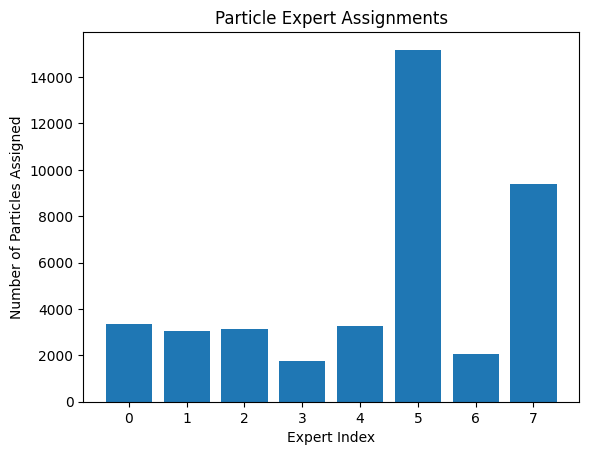

In [28]:
import matplotlib.pyplot as plt

particle_assignments = np.array(router_hook.expert_assignments)
particle_assignments_hist = np.sum(particle_assignments, axis=0)
plt.bar(np.arange(router_hook.model.moe_num_experts), particle_assignments_hist)
plt.xlabel('Expert Index')
plt.ylabel('Number of Particles Assigned')
plt.title('Particle Expert Assignments')
plt.show()

In [35]:
print(router_hook.cls_expert_weights[:20])
print(router_hook.cls_expert_assignments.shape)

tensor([[0.0000, 0.0000, 0.0000, 0.4991, 0.0000, 0.0000, 0.0000, 0.5009],
        [0.4713, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5287],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5203, 0.0000, 0.4797],
        [0.0000, 0.0000, 0.4823, 0.0000, 0.0000, 0.0000, 0.0000, 0.5177],
        [0.4277, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5723],
        [0.0000, 0.0000, 0.0000, 0.4997, 0.0000, 0.0000, 0.0000, 0.5003],
        [0.0000, 0.0000, 0.5334, 0.4666, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.4596, 0.0000, 0.0000, 0.0000, 0.5404],
        [0.0000, 0.0000, 0.5018, 0.0000, 0.0000, 0.0000, 0.0000, 0.4982],
        [0.4948, 0.0000, 0.0000, 0.5052, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.4644, 0.5356, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.5448, 0.0000, 0.0000, 0.0000, 0.4552],
        [0.0000, 0.0000, 0.5134, 0.0000, 0.4866, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5323, 0.000

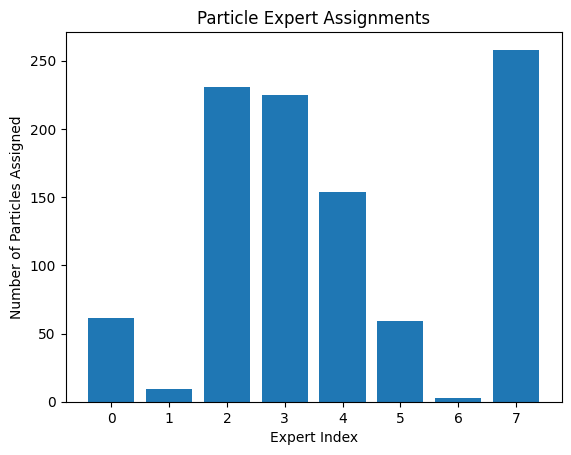

In [29]:
class_assignments = np.array(router_hook.cls_expert_assignments)
class_assignments_hist = np.sum(class_assignments, axis=0)
plt.bar(np.arange(router_hook.model.moe_num_experts), class_assignments_hist)
plt.xlabel('Expert Index')
plt.ylabel('Number of Particles Assigned')
plt.title('Particle Expert Assignments')
plt.show()

In [ ]:
# PLAN: Sort by assigned expert
# Define feature subspaces to search for correlations e.g. angular space, momentum, charge, particle type
# Compute average norm between all particles of given expert in these subspaces
# In the average, weight by the expert's weighting
# Could do scatterplots to demonstrate

In [ ]:
# Angular subspace: (eta, phi) at indices 

In [30]:
# Charge, particle types at indices 5 and 6-10 (ChargedHadron, NeutralHadron, Photon, Electron, Muon)

flat_features = features.transpose(0,2,1)

# features: (N, P, C) -> (N*P, C)
flat_features = flat_features.reshape(-1, features.shape[1])

print(flat_features.shape)
print(flat_features[0,:])
flat_features = flat_features[router_hook.valid_indices,:]
print(flat_features.shape)

assignments = {i: [] for i in range(router_hook.model.moe_num_experts)}
weights = {i: [] for i in range(router_hook.model.moe_num_experts)}

(64000, 17)
[ 2.270114    2.0825253   2.0615487   2.0429313  -0.35085368  1.
  0.          0.          0.          1.          0.          0.07694232
  0.011       0.03058507  0.0318     -0.07242048 -0.08581114]
(20575, 17)


In [31]:
for part in range(len(flat_features)):
    for expert in range(router_hook.model.moe_num_experts):
        if router_hook.expert_assignments[part, expert] == 1:
            assignments[expert].append(flat_features[part,:])
            weights[expert].append(router_hook.expert_weights[part, expert])

In [32]:
print(assignments[3][0])

[ 1.9998076   1.8451487   1.7912426   1.8055545  -0.32082492  0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.07607916  0.09253383]


In [42]:
# Then look at assignments, which combinations are the most common?
# Probably create 2D grid to demonstrate

expert_pairs = np.zeros((router_hook.model.moe_num_experts, router_hook.model.moe_num_experts))

for part in router_hook.expert_assignments:
    assigned_experts = np.where(part==1)[0]
    expert_pairs[assigned_experts[0], assigned_experts[1]] += 1
    expert_pairs[assigned_experts[1], assigned_experts[0]] += 1
    # normalize to fractions of total particles
    

In [46]:
print(expert_pairs)

[[0.000e+00 9.200e+01 1.900e+01 5.400e+01 3.870e+02 2.667e+03 0.000e+00
  1.180e+02]
 [9.200e+01 0.000e+00 9.600e+01 1.400e+01 3.200e+01 2.552e+03 0.000e+00
  2.430e+02]
 [1.900e+01 9.600e+01 0.000e+00 6.500e+01 1.860e+02 2.569e+03 3.000e+00
  2.050e+02]
 [5.400e+01 1.400e+01 6.500e+01 0.000e+00 4.110e+02 7.400e+02 0.000e+00
  4.840e+02]
 [3.870e+02 3.200e+01 1.860e+02 4.110e+02 0.000e+00 1.250e+03 6.000e+00
  9.900e+02]
 [2.667e+03 2.552e+03 2.569e+03 7.400e+02 1.250e+03 0.000e+00 6.100e+01
  5.339e+03]
 [0.000e+00 0.000e+00 3.000e+00 0.000e+00 6.000e+00 6.100e+01 0.000e+00
  1.992e+03]
 [1.180e+02 2.430e+02 2.050e+02 4.840e+02 9.900e+02 5.339e+03 1.992e+03
  0.000e+00]]


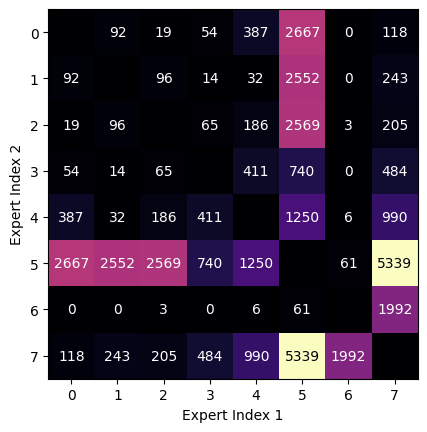

In [48]:
fig, ax = plt.subplots()
im = ax.imshow(expert_pairs, cmap='magma')

rows, cols = expert_pairs.shape
for i in range(rows):
    for j in range(cols):
        if j != i:
            text = ax.text(j, i, int(expert_pairs[i, j]),
                       ha="center", va="center", color="w") # Customize text color if needed
        if [i,j] == [5,7] or [i,j] == [7,5]:
            text = ax.text(j, i, int(expert_pairs[i, j]),
                       ha="center", va="center", color="black") # Customize text color if needed

plt.xlabel('Expert Index 1')
plt.ylabel('Expert Index 2')
plt.show()

In [ ]:
# consider high-level overviews: for each decay, plot expert distributions
# consider for particle types, what experts like them
# consider ranges of pT
# consider angle off the jet-axis to indicate particular decay, also (px, py, pz) if we can get some good scaling
# we'd like the model to recognize cross-section etc.
# probably some automation to generate plots more efficiently